In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
subdata = pd.read_csv("ML - Curricular Analytics - PIDM ONLY.csv", nrows=40)
df = pd.read_csv("ML - Curricular Analytics - PIDM ONLY.csv")

In [3]:
total_students = df['Pidm'].nunique()
print(f'Total distinct students: {total_students}')

Total distinct students: 105883


In [4]:
citizenship_distribution = df['CITZ_IND'].value_counts()

C1 = citizenship_distribution.get('Y', 0)  # 'Y' for U.S. citizens
C2 = citizenship_distribution.get('N', 0)  # 'N' for non-citizens

print(f'U.S. citizens: {C1}')
print(f'Non-citizens: {C2}')

U.S. citizens: 2479471
Non-citizens: 184086


In [6]:
# Convert SAT and ACT columns to numeric, forcing invalid entries like '-' to NaN
df['SAT_TOTAL'] = pd.to_numeric(df['SAT_TOTAL'], errors='coerce')
df['EACT'] = pd.to_numeric(df['EACT'], errors='coerce')

# Group by Pidm to ensure we are counting unique students
# For students who took the SAT, filter distinct students who have a SAT_TOTAL > 0
S = df[df['SAT_TOTAL'] > 0].drop_duplicates(subset=['Pidm'])['Pidm'].count()

# For students who took the ACT, filter distinct students who have an EACT > 0
A = df[df['EACT'] > 0].drop_duplicates(subset=['Pidm'])['Pidm'].count()

# For students who took both the SAT and ACT, filter distinct students who have both SAT_TOTAL > 0 and EACT > 0
both = df[(df['SAT_TOTAL'] > 0) & (df['EACT'] > 0)].drop_duplicates(subset=['Pidm'])['Pidm'].count()

print(f'Students who took the SAT: {S}')
print(f'Students who took the ACT: {A}')
print(f'Students who took both SAT and ACT: {both}')

Students who took the SAT: 69234
Students who took the ACT: 53571
Students who took both SAT and ACT: 26563


In [13]:
# Combine 'SUBJ' and 'CRSE_NUMB' into a single 'Course' column
df['Course'] = df[['SUBJ', 'CRSE_NUMB']].apply(lambda x: f"{x['SUBJ']}{x['CRSE_NUMB']}", axis=1)
grades_df = pd.read_csv("parsed_grades.csv")

# Merge the two dataframes to bring in the Quality Points based on the grade code
df = pd.merge(df, grades_df[['Code', 'Quality Points']], left_on='SHRTCKG_GRDE_CODE_FINAL', right_on='Code', how='left', suffixes=('', '_grades'))

# Fill missing 'Quality Points' with 0.0 for unrecognized grades
df['Quality Points'] = df['Quality Points'].fillna(0.0)

# Filter the columns
selected_columns = [
    'Pidm', 'Admit_Level', 'Admit_College', 'Admit_Major_Code', 'Major_Desc',
    'Race', 'NEW_ETHNICITY', 'GENDER_Code', 'CITZ_IND', 'CITZ_DESC',
    'Quality Points', 'ACTE', 'ACTM', 'ACTR', 'ACTS', 'EACT', 'SAT-ERW',
    'SATM', 'SAT_TOTAL', 'Term', 'Course'
]
df_filtered = df[selected_columns]

# Group by 'Pidm' and 'Term' (Semester), calculate the average GPA using 'Quality Points', and aggregate courses into an array
grouped_df = df_filtered.groupby(['Pidm', 'Term']).agg({
    'Admit_Level': 'first',
    'Admit_College': 'first',
    'Admit_Major_Code': 'first',
    'Major_Desc': 'first',
    'Race': 'first',
    'NEW_ETHNICITY': 'first',
    'GENDER_Code': 'first',
    'CITZ_IND': 'first',
    'CITZ_DESC': 'first',
    'Quality Points': [
        ('Semester_GPA', 'mean'),               # Calculate the mean GPA for each term
        ('Course_Grades', lambda x: list(x))    # Gather grades into an array for each course
    ],
    'ACTE': 'first',
    'ACTM': 'first',
    'ACTR': 'first',
    'ACTS': 'first',
    'EACT': 'first',
    'SAT-ERW': 'first',
    'SATM': 'first',
    'SAT_TOTAL': 'first',
    'Course': lambda x: list(x)  # Gather GPA points into an array (for 'Course Grades')
}).reset_index()
# Rename columns
grouped_df.columns = ['Pidm', 'Term', 'Admit_Level', 'Admit_College', 'Admit_Major_Code', 'Major_Desc', 'Race',
                      'NEW_ETHNICITY', 'GENDER_Code', 'CITZ_IND', 'CITZ_DESC', 'Semester_GPA', 'Course_Grades',
                      'ACTE', 'ACTM', 'ACTR', 'ACTS', 'EACT', 'SAT_ERW', 'SATM', 'SAT_TOTAL', 'Courses']

# Move 'Semester_GPA' and 'Course_Grades' to the desired position
columns_order = grouped_df.columns.tolist()
columns_order.remove('Semester_GPA')
columns_order.remove('Course_Grades')

# Reorder the columns with 'Semester_GPA' and 'Course_Grades' at the end
columns_order += ['Semester_GPA', 'Course_Grades']
grouped_df = grouped_df[columns_order]

# Ensure GPA is capped at 4.0 and round it to 2 decimal places
grouped_df['Semester_GPA'] = grouped_df['Semester_GPA'].apply(lambda x: min(x, 4.0)).round(2)

In [14]:
grouped_df.to_csv("clean_data.csv", index=False)

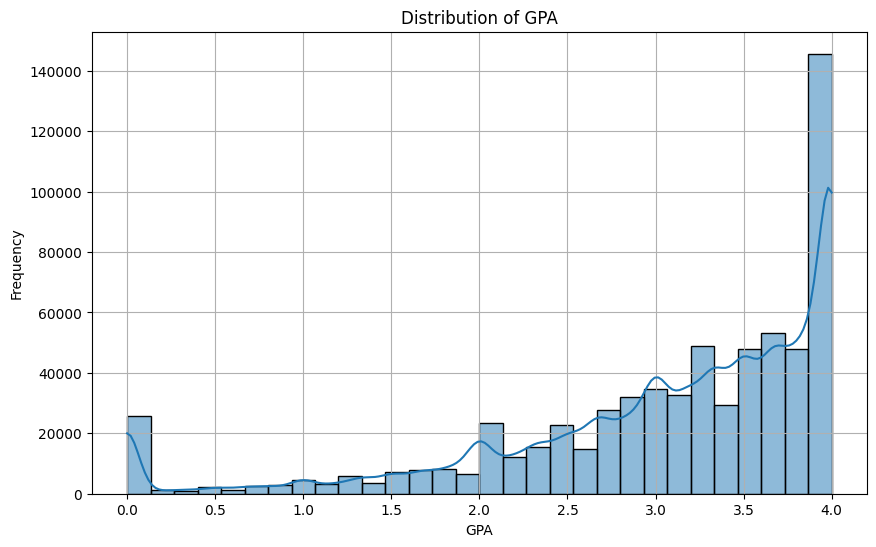

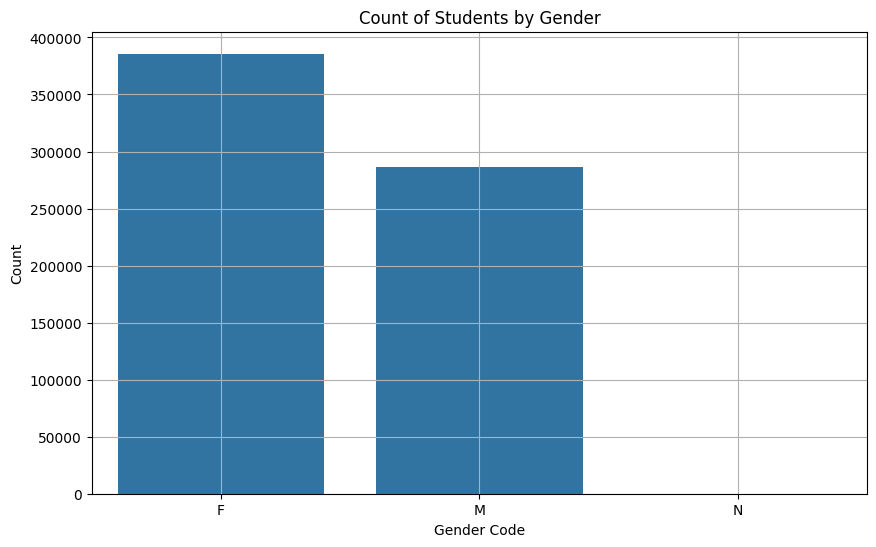

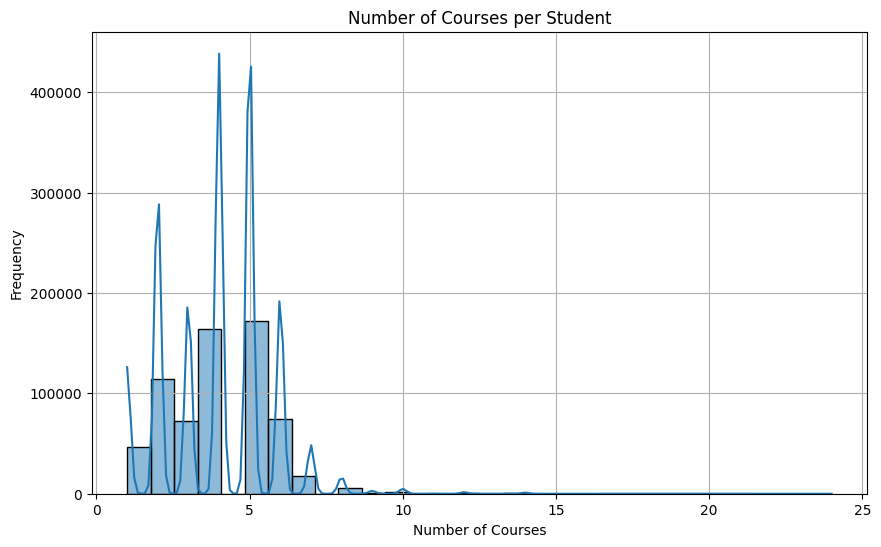

In [17]:
# Visualize the distribution of GPA
grouped_df['Semester_GPA'] = grouped_df['Semester_GPA'].apply(lambda x: min(x, 4.0))
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Semester_GPA'], bins=30, kde=True)
plt.title('Distribution of GPA')
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualize the count of students by Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=grouped_df, x='GENDER_Code')
plt.title('Count of Students by Gender')
plt.xlabel('Gender Code')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Visualize the number of courses per student
grouped_df['Num_Courses'] = grouped_df['Courses'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Num_Courses'], bins=30, kde=True)
plt.title('Number of Courses per Student')
plt.xlabel('Number of Courses')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()